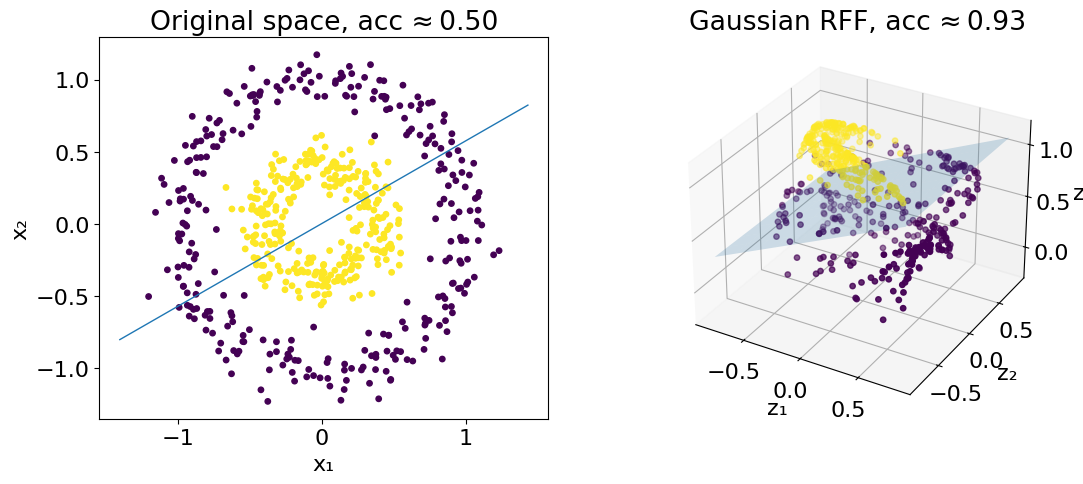

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 – needed for 3‑D projection
from sklearn.datasets import make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler

# 1. 2‑D data that are **not** linearly separable
X, y = make_circles(n_samples=600, noise=0.1, factor=0.4, random_state=0)

# 2. Linear model in the original space (for reference)
clf_orig = LogisticRegression(max_iter=1000).fit(X, y)
acc_orig = clf_orig.score(X, y)

# 3. Map inputs with 3 Random Fourier Features drawn from the Gaussian kernel
gamma = 0.5               #  γ = 1/(2σ²)
rff = RBFSampler(gamma=gamma, n_components=3, random_state=0)
Z = rff.fit_transform(X)   # Z lives in ℝ³

# 4. Same linear model, but **in Z‑space**
clf_rff = LogisticRegression(max_iter=1000).fit(Z, y)
acc_rff = clf_rff.score(Z, y)
w, b = clf_rff.coef_.ravel(), clf_rff.intercept_[0]

# 5. Plot: original vs. RFF space + separating hyperplane
fig = plt.figure(figsize=(12, 5))

# ----- left: original 2‑D space -----
ax0 = fig.add_subplot(1, 2, 1)
ax0.scatter(X[:, 0], X[:, 1], c=y, s=15)
# decision line in original space (it’s linear here, but useless)
xs = np.linspace(X[:, 0].min() - .2, X[:, 0].max() + .2, 200)
ys = -(clf_orig.coef_[0, 0] * xs + clf_orig.intercept_[0]) / clf_orig.coef_[0, 1]
ax0.plot(xs, ys, linewidth=1)
ax0.set_xlabel("x₁")
ax0.set_ylabel("x₂")
ax0.set_aspect("equal", adjustable="box")
ax0.set_title(f"Original space, acc ≈ {acc_orig:.2f}")

# ----- right: 3‑D RFF space -----
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=y, s=15)

# plane: w₁x + w₂y + w₃z + b = 0  →  z = −(w₁x + w₂y + b)/w₃
grid = np.linspace(Z.min(), Z.max(), 10)
XX, YY = np.meshgrid(grid, grid)
ZZ = -(w[0] * XX + w[1] * YY + b) / w[2]
ax1.plot_surface(XX, YY, ZZ, alpha=0.2)

ax1.set_xlabel("z₁")
ax1.set_ylabel("z₂")
ax1.set_zlabel("z₃")
ax1.set_title(f"Gaussian RFF, acc ≈ {acc_rff:.2f}")

plt.tight_layout()

# increase font size
plt.rcParams.update({"font.size": 16})

# save as pdf 
plt.savefig("rff_3d.pdf", bbox_inches="tight")


In [7]:
from __future__ import annotations

import argparse
import math
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sns.set(style="whitegrid", context="paper", font_scale=1.6)  # global seaborn style

# ---------------------------
#  Utility – reproducibility
# ---------------------------

def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# ---------------------------
#  Model and kernel helpers
# ---------------------------

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int]):
        super().__init__()
        layers: List[nn.Module] = []
        dims = [in_dim] + hidden
        for i in range(len(hidden)):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class RFF(nn.Module):
    def __init__(self, in_dim: int, num_features: int = 512, sigma: float = 1.0):
        super().__init__()
        omega = torch.randn(in_dim, num_features) / sigma
        self.register_buffer("omega", omega)
        self.scale = math.sqrt(2.0 / num_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        proj = x @ self.omega
        return self.scale * torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)


def ntk_between(model: nn.Module, x: torch.Tensor, x_prime: torch.Tensor) -> torch.Tensor:
    model.zero_grad(set_to_none=True)
    model(x.unsqueeze(0)).backward(retain_graph=True)
    g1 = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
    model.zero_grad(set_to_none=True)
    model(x_prime.unsqueeze(0)).backward()
    g2 = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
    return torch.dot(g1, g2)


# -----------------------------------------
#  Experiment 1 – Kernel‑norm explosion
# -----------------------------------------

def kernel_norm_data(
    in_dim: int,
    hidden: Tuple[int, ...],
    rff_features: int,
    sigma: float,
    radii: Tuple[float, float],
    num_points: int,
    device,
    seed: int,
):
    set_seed(seed)
    raw_mlp = MLP(in_dim, list(hidden)).to(device)
    rff_layer = RFF(in_dim, rff_features, sigma).to(device)
    rff_mlp = MLP(2 * rff_features, list(hidden)).to(device)

    rs = torch.logspace(math.log10(radii[0]), math.log10(radii[1]), num_points, device=device)
    k_raw, k_rff = [], []
    for r in rs:
        x, xp = torch.randn(2, in_dim, device=device)
        x, xp = r * x / x.norm(), r * xp / xp.norm()
        k_raw.append(ntk_between(raw_mlp, x, xp).abs().item())
        z, zp = rff_layer(x), rff_layer(xp)
        k_rff.append(ntk_between(rff_mlp, z, zp).abs().item())
    return rs.cpu().numpy(), np.array(k_raw), np.array(k_rff)


# -----------------------------------------
#  Experiment 2 – Convergence speed
# -----------------------------------------

def make_regression_data(
    n_samples: int,
    in_dim: int,
    rff_features: int,
    alpha: float,
    sigma: float,
    noise_std: float,
    device,
):
    X = torch.randn(n_samples, in_dim, device=device)
    rff_layer = RFF(in_dim, rff_features, sigma).to(device)
    with torch.no_grad():
        w_raw = torch.randn(in_dim, 1, device=device)
        Z = rff_layer(X)
        w_rff = torch.randn(Z.shape[1], 1, device=device)
        y = (1 - alpha) * (X @ w_raw) + alpha * (Z @ w_rff) + noise_std * torch.randn(n_samples, 1, device=device)
    return X, y, rff_layer


def train_curve(
    X: torch.Tensor,
    y: torch.Tensor,
    rff_layer: RFF,
    in_dim: int,
    hidden: Tuple[int, ...],
    rff_features: int,
    n_steps: int,
    batch_size: int,
    lr: float,
):
    device = X.device
    raw_mlp = MLP(in_dim, list(hidden)).to(device)
    rff_mlp = MLP(2 * rff_features, list(hidden)).to(device)

    # helper
    def run(model, Xtrain):
        opt = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.5)
        steps, losses = [0], [F.mse_loss(model(Xtrain), y).item()]
        for step in range(1, n_steps + 1):
            idx = torch.randint(0, Xtrain.shape[0], (batch_size,), device=device)
            loss = F.mse_loss(model(Xtrain[idx]), y[idx])
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            scheduler.step()
            if step % 100 == 0:
                steps.append(step)
                with torch.no_grad():
                    losses.append(F.mse_loss(model(Xtrain), y).item())
        return np.array(steps), np.array(losses)

    steps_raw, mse_raw = run(raw_mlp, X)
    with torch.no_grad():
        Z = rff_layer(X)
    steps_rff, mse_rff = run(rff_mlp, Z)
    return steps_raw, mse_raw, steps_rff, mse_rff


def plot_convergence(ax, ax_idx, steps_raw, mse_raw, steps_rff, mse_rff, alpha):
    ax.semilogy(steps_raw, mse_raw, label="Raw inputs")
    ax.semilogy(steps_rff, mse_rff, label="RFF inputs")
    # bias indicator at iter 0
    ax.vlines(0, min(mse_raw[0], mse_rff[0]), max(mse_raw[0], mse_rff[0]), ls="--", color="gray")
    ax.scatter([0], [mse_raw[0]], color=ax.lines[0].get_color())
    ax.scatter([0], [mse_rff[0]], color=ax.lines[1].get_color())
    # slope annotations
    for label, steps, mse in zip(["Raw", "RFF"], [steps_raw, steps_rff], [mse_raw, mse_rff]):
        k = min(10, len(steps))
        slope = np.polyfit(steps[-k:], np.log(mse[-k:]), 1)[0]
        y_text = 0.95 if label == "RFF" else 0.88
        ax.text(0.98, y_text, f"{label} slope: {slope:.2e}", transform=ax.transAxes, ha="right", va="top", fontsize=10)
    ax.set_title(f"MSE Convergence, α = {alpha}")
    ax.set_xlabel("SGD steps")
    if ax_idx == 1:
        ax.set_ylabel("MSE (log)")


# -----------------------------------------
#  Composite panel
# -----------------------------------------

def experiment_panel(
    alpha_list: List[float],
    in_dim: int = 10,
    hidden: Tuple[int, ...] = (128, 128),
    rff_features: int = 512,
    sigma: float = 1.0,
    radii: Tuple[float, float] = (1.0, 1e4),
    num_points: int = 60,
    n_samples: int = 4000,
    n_steps: int = 5000,
    batch_size: int = 256,
    lr: float = 1e-3,
    seed: int = 0,
    device: str | torch.device | None = None,
):
    dev = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))

    # figure layout: 1 row (kernel + len(alpha_list) convergence plots)
    n_cols = 1 + len(alpha_list)
    fig, axs = plt.subplots(1, n_cols, figsize=(5 * n_cols, 4), sharey=False)

    # leftmost: kernel norm explosion
    rs, k_raw, k_rff = kernel_norm_data(
        in_dim, hidden, rff_features, sigma, radii, num_points, dev, seed
    )
    ax0 = axs[0]
    ax0.loglog(rs, k_raw, label="Raw inputs")
    ax0.loglog(rs, k_rff, label="RFF inputs")
    ax0.set_title("Kernel norm explosion")
    ax0.set_xlabel(r"‖x‖ = ‖x'‖")
    ax0.set_ylabel(r"|K_t(x,x')|")
    ax0.legend(fontsize=9)

    # convergence subplots
    for idx, alpha in enumerate(alpha_list, start=1):
        set_seed(seed)  # ensure fair comparison per alpha
        X, y, rff_layer = make_regression_data(
            n_samples, in_dim, rff_features, alpha, sigma, 0.1, dev
        )
        steps_raw, mse_raw, steps_rff, mse_rff = train_curve(
            X, y, rff_layer, in_dim, hidden, rff_features, n_steps, batch_size, lr
        )
        plot_convergence(axs[idx], idx, steps_raw, mse_raw, steps_rff, mse_rff, alpha)
        if idx == len(alpha_list):
            axs[idx].legend(fontsize=9)

    plt.tight_layout()
    plt.savefig("panel.png", dpi=180)
    print("[Panel] panel.png saved with kernel plot and convergence subplots")

[Panel] panel.png saved with kernel plot and convergence subplots


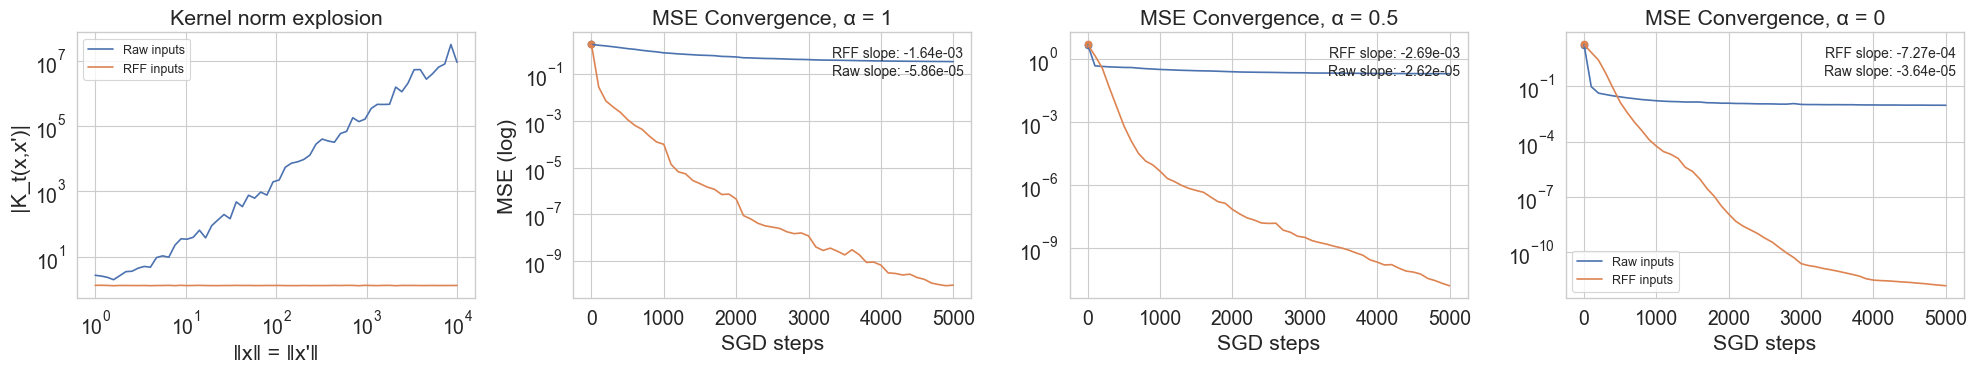

In [8]:
experiment_panel([1, 0.5, 0])